# Machine Learning 1 - Aprendizado Não Supervisionado  
Prof: Nielsen Rechia

### Autores: 
Roberto Coutinho  
Thais Galho

### Atividade:  Analizar o Censo Americano usando modelos Particionais e Hierárquivos

##### Requisitos
- Agrupe os dados do censo americano de 2005 com o K-means e algum algoritmo hierarquico  
- Não considerar a classe do conjunto de dados  
- Somente um conjunto de dados  
- Dados devem ser pré-processados  
- Usar vários números de grupos (ex: 2 a 20)  
- Medir a qualidade dos grupos com a silhueta (podem usar outros também)  

##### Perguntas a serem respondidas
- [Qual é o melhor número de grupos?](#question1)
- [Qual é o melhor algoritmo? Motivos?](#question2)
- [Resultados complementares](#complement)  

##### Observações
Entregar via BB o código python ou jupyter e o passo a passo realizado (ex, motivos do pre-processamento etc.) em um zip.

## Imports

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from sklearn.metrics import confusion_matrix



## Leitura do dataset e exploração

In [110]:
columns= ["age", 
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "class"]

censo = pd.read_csv('censo/adult.data', 
                    nrows=None, 
                    header=None,
                    index_col=None)

censo.columns = columns

print str(len(censo)) + ' total records' 
    
censo.head(5)

32561 total records


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Visualização para análise exploratória

O gráfico abaixo plota a distribuição pareada entre as combinações de caracteristicas do dataset, onde a cor é a classe real.

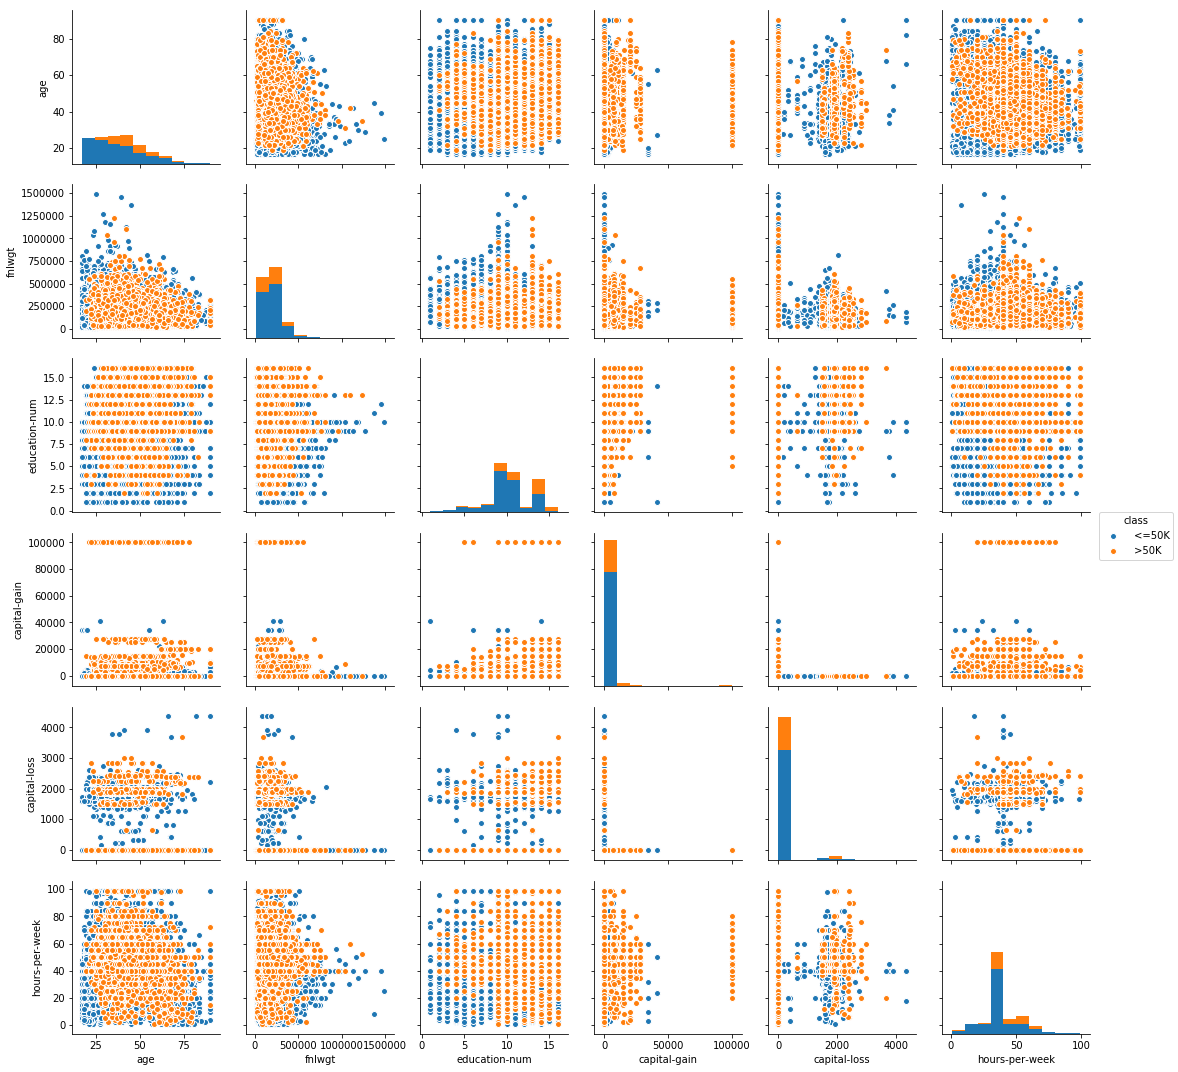

In [5]:
#visualização dos dados rotulados por classes
import seaborn as sb
sb.pairplot(censo, hue='class')

## Pré-processamento 

Segundo o artigo [***'Predicting if income exceeds $50,000 per year based on 1994 US Census Data with Simple Classification Techniques'***](https://www.google.com/url?q=https://cseweb.ucsd.edu/~jmcauley/cse190/reports/sp15/048.pdf&sa=D&source=hangouts&ust=1532639687362000&usg=AFQjCNHleYm0Gew-N6zDO2oe5EHvFKGcTA), eles usaram como principais caracteristicas para determinar a dissimilaridade entre as classes os seguintes atributos:  ’age’, ‘sex’, ‘education’ e ‘occupation’. 

Seguindo a sugestão dos autores, que demonstraram no artigo as distribuições de todos os atributos, vamos utilizar os mesmo atributos descritos no artigo como base line para nosso experimento.



In [111]:
columns_to_filter = ["age", "sex", "education", "occupation","hours-per-week","class"]

df = censo.loc[:, columns_to_filter]

#### Dataset sampling
Nesse trecho tivemos que fazer um subsampling pois estava demorando na execução dos algoritmos devido ao tamanho do dataset. Obs. Para fins do experimento, utilizamos a fração de 40% do dataset estratificado, porém é possível alterar.

In [112]:
df = df.sample(frac=0.4) 
print str(len(df)) + ' records'

df.head()

13024 records


,age,sex,education,occupation,hours-per-week,class
1282,65,Male,HS-grad,?,40,>50K
32467,55,Male,9th,Craft-repair,48,<=50K
31355,42,Male,Some-college,Exec-managerial,45,>50K
15075,51,Male,Masters,Prof-specialty,35,>50K
2340,27,Female,Some-college,?,25,<=50K


#### Separação entre labels e dataset
Nessa etapa, separamos o atributo "rótulo" e mantemos os demais atributos no dataset a fim de termos os "rotulos" originais separados para posteriomente avaliarmos contra nosso "ground truth".

In [113]:
df['class'] = df['class'].astype('category')
categories = df.select_dtypes(['category']).columns
df[categories] = df[categories].apply(lambda x:x.cat.codes) 

Y_labels = df["class"]
#print Y_labels

df.drop(columns=["class"] ,inplace=True) ## Não pode rodar duas vezes
df.head()

,age,sex,education,occupation,hours-per-week
1282,65,Male,HS-grad,?,40
32467,55,Male,9th,Craft-repair,48
31355,42,Male,Some-college,Exec-managerial,45
15075,51,Male,Masters,Prof-specialty,35
2340,27,Female,Some-college,?,25


#### Discretização dos atributos categóricos
Nessa etapa de pré-processamento, transformamos os atributos categóricos em uma matriz de frequencia. 

In [114]:
# Encoding categorical data

df = pd.get_dummies(df)
print str(len(df)) + ' records'
df.head()


13024 records


,age,hours-per-week,sex_ Female,sex_ Male,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,...,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving
1282,65,40,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32467,55,48,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31355,42,45,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15075,51,35,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2340,27,25,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Verificação de valores nulos
Nessa etapa, a gente verifica se o dataset possui algum atributo com valores nulos.

In [115]:
#confirmando que não tem dados nulos a serem tratados
df.isnull().sum()

age                              0
hours-per-week                   0
sex_ Female                      0
sex_ Male                        0
education_ 10th                  0
education_ 11th                  0
education_ 12th                  0
education_ 1st-4th               0
education_ 5th-6th               0
education_ 7th-8th               0
education_ 9th                   0
education_ Assoc-acdm            0
education_ Assoc-voc             0
education_ Bachelors             0
education_ Doctorate             0
education_ HS-grad               0
education_ Masters               0
education_ Preschool             0
education_ Prof-school           0
education_ Some-college          0
occupation_ ?                    0
occupation_ Adm-clerical         0
occupation_ Armed-Forces         0
occupation_ Craft-repair         0
occupation_ Exec-managerial      0
occupation_ Farming-fishing      0
occupation_ Handlers-cleaners    0
occupation_ Machine-op-inspct    0
occupation_ Other-se

### Execução 
Esse trecho abaixo executa a clusterização para diversas configurações de K usando K-Means e Linkage, e após a execução, apresenta os resultados através das métricas Silhueta e Calinsky.

In [116]:

scores = pd.DataFrame(columns=["n_clusters", 
                               "silhuete metric",
                               "calinski metric", 
                               "method",])

num_of_max_clusters = 20  # Number of clusters

print "Number of max clusters to validate : "+str(num_of_max_clusters)
print
print '##########################################################'
print

for i in range(2, num_of_max_clusters):
    
    print 'Starting processing with '+str(i)+' clusters...'
    
    ##########################################################
    # Run kmeans
    ##########################################################    
    print 'Running K-Means...'
    
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++', 
                    n_init=10, 
                    max_iter=300)
    
    kmeans_clust = kmeans.fit(df)
    
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_    
    
    #Calculate the scores
    score_silhuete = silhouette_score(df,labels)
    score_ca = calinski_harabaz_score(df,labels)   
    
    #Add to score dataframe
    scores.loc[len(scores)] = [i, score_silhuete, score_ca, 'kmeans']
    
    ##########################################################
    # Run linkage
    ##########################################################
    print 'Running Linkage...'
    
    link = linkage(df, 'single')
    
    clusters = fcluster(link, 
                        i, 
                        criterion='maxclust')
    
    #Calculate the scores
    score_silhuete_link = silhouette_score(df,clusters)
    score_ca_link = calinski_harabaz_score(df,clusters)    
    
    #Add to score dataframe
    scores.loc[len(scores)] = [i, score_silhuete_link, score_ca_link, 'linkage']
    
    # Print results
    print 'Results :'
    print
    print 'Metrics:'
    print scores.sort_values(['silhuete metric', 'calinski metric'], ascending=[False, False])
    print
    print 'Centroids:'
    print centroids
    print
    print 'Labels:'
    print labels
    print 
    print
    print '--------------------------------'
    print 

Number of max clusters to validate : 20

##########################################################

Starting processing with 2 clusters...
Running K-Means...
Running Linkage...
Results :

Metrics:
  n_clusters  silhuete metric  calinski metric   method
1          2         0.663798        27.100833  linkage
0          2         0.381431      7844.258947   kmeans

Centroids:
[[ 2.90168878e+01  3.91300094e+01  3.63088058e-01  6.36911942e-01
   3.16311486e-02  4.53022383e-02  1.55475137e-02  3.08269669e-03
   7.90778716e-03  1.04543627e-02  1.48773623e-02  3.69923603e-02
   4.57043292e-02  1.69548318e-01  5.36121163e-03  3.19260153e-01
   3.43117545e-02  1.34030291e-03  1.16606353e-02  2.47017826e-01
   5.74989948e-02  1.29875352e-01  1.34030291e-04  1.27060716e-01
   9.75740517e-02  2.73421793e-02  5.53545101e-02  6.20560247e-02
   1.14863959e-01  4.15493902e-03  1.15400080e-01  1.98364830e-02
   1.15266050e-01  3.05589063e-02  4.30237234e-02]
 [ 5.16563006e+01  4.20021571e+01  2.867158

Running Linkage...
Results :

Metrics:
  n_clusters  silhuete metric  calinski metric   method
1          2         0.663798        27.100833  linkage
3          3         0.556681        17.772797  linkage
5          4         0.543723        14.532228  linkage
7          5         0.522013        13.540961  linkage
9          6         0.503012        16.114054  linkage
6          5         0.422963      9085.454516   kmeans
4          4         0.407054      8316.668748   kmeans
8          6         0.389804      9756.687692   kmeans
2          3         0.386552      7891.304923   kmeans
0          2         0.381431      7844.258947   kmeans

Centroids:
[[ 5.65672665e+01  4.20591260e+01  2.80205656e-01  7.19794344e-01
   3.64181662e-02  2.57069409e-02  7.28363325e-03  9.42587832e-03
   1.62810626e-02  3.77035133e-02  2.65638389e-02  2.01371037e-02
   3.72750643e-02  1.33676093e-01  2.52784919e-02  3.42759212e-01
   7.75492716e-02  2.99914310e-03  1.97086547e-02  1.81233933e-01
   

Running Linkage...
Results :

Metrics:
   n_clusters  silhuete metric  calinski metric   method
1           2         0.663798        27.100833  linkage
3           3         0.556681        17.772797  linkage
5           4         0.543723        14.532228  linkage
7           5         0.522013        13.540961  linkage
9           6         0.503012        16.114054  linkage
11          7         0.493034        13.440033  linkage
13          8         0.463403        12.449643  linkage
6           5         0.422963      9085.454516   kmeans
4           4         0.407054      8316.668748   kmeans
10          7         0.392000      9435.377211   kmeans
8           6         0.389804      9756.687692   kmeans
2           3         0.386552      7891.304923   kmeans
0           2         0.381431      7844.258947   kmeans
12          8         0.361352      9307.906774   kmeans

Centroids:
[[ 6.13111285e+01  4.11802508e+01  2.75078370e-01  7.24921630e-01
   4.46708464e-02  3.0564263

Running Linkage...
Results :

Metrics:
   n_clusters  silhuete metric  calinski metric   method
1           2         0.663798        27.100833  linkage
3           3         0.556681        17.772797  linkage
5           4         0.543723        14.532228  linkage
7           5         0.522013        13.540961  linkage
9           6         0.503012        16.114054  linkage
11          7         0.493034        13.440033  linkage
13          8         0.463403        12.449643  linkage
17         10         0.462453        54.870826  linkage
15          9         0.458126        11.708212  linkage
6           5         0.422963      9085.454516   kmeans
4           4         0.407054      8316.668748   kmeans
10          7         0.392000      9435.377211   kmeans
8           6         0.389804      9756.687692   kmeans
2           3         0.386552      7891.304923   kmeans
0           2         0.381431      7844.258947   kmeans
16         10         0.374849      9601.939534  

Running Linkage...
Results :

Metrics:
   n_clusters  silhuete metric  calinski metric   method
1           2         0.663798        27.100833  linkage
3           3         0.556681        17.772797  linkage
5           4         0.543723        14.532228  linkage
7           5         0.522013        13.540961  linkage
9           6         0.503012        16.114054  linkage
11          7         0.493034        13.440033  linkage
13          8         0.463403        12.449643  linkage
19         11         0.462563        57.618047  linkage
17         10         0.462453        54.870826  linkage
15          9         0.458126        11.708212  linkage
6           5         0.422963      9085.454516   kmeans
4           4         0.407054      8316.668748   kmeans
21         12         0.404885        54.815681  linkage
10          7         0.392000      9435.377211   kmeans
8           6         0.389804      9756.687692   kmeans
2           3         0.386552      7891.304923  

Running Linkage...
Results :

Metrics:
   n_clusters  silhuete metric  calinski metric   method
1           2         0.663798        27.100833  linkage
3           3         0.556681        17.772797  linkage
5           4         0.543723        14.532228  linkage
7           5         0.522013        13.540961  linkage
9           6         0.503012        16.114054  linkage
11          7         0.493034        13.440033  linkage
13          8         0.463403        12.449643  linkage
19         11         0.462563        57.618047  linkage
17         10         0.462453        54.870826  linkage
15          9         0.458126        11.708212  linkage
6           5         0.422963      9085.454516   kmeans
4           4         0.407054      8316.668748   kmeans
21         12         0.404885        54.815681  linkage
23         13         0.396413        50.250809  linkage
10          7         0.392000      9435.377211   kmeans
8           6         0.389804      9756.687692  

Running Linkage...
Results :

Metrics:
   n_clusters  silhuete metric  calinski metric   method
1           2         0.663798        27.100833  linkage
3           3         0.556681        17.772797  linkage
5           4         0.543723        14.532228  linkage
7           5         0.522013        13.540961  linkage
9           6         0.503012        16.114054  linkage
11          7         0.493034        13.440033  linkage
13          8         0.463403        12.449643  linkage
19         11         0.462563        57.618047  linkage
17         10         0.462453        54.870826  linkage
15          9         0.458126        11.708212  linkage
6           5         0.422963      9085.454516   kmeans
4           4         0.407054      8316.668748   kmeans
21         12         0.404885        54.815681  linkage
23         13         0.396413        50.250809  linkage
25         14         0.395218        47.448249  linkage
10          7         0.392000      9435.377211  

Running Linkage...
Results :

Metrics:
   n_clusters  silhuete metric  calinski metric   method
1           2         0.663798        27.100833  linkage
3           3         0.556681        17.772797  linkage
5           4         0.543723        14.532228  linkage
7           5         0.522013        13.540961  linkage
9           6         0.503012        16.114054  linkage
11          7         0.493034        13.440033  linkage
13          8         0.463403        12.449643  linkage
19         11         0.462563        57.618047  linkage
17         10         0.462453        54.870826  linkage
15          9         0.458126        11.708212  linkage
6           5         0.422963      9085.454516   kmeans
4           4         0.407054      8316.668748   kmeans
21         12         0.404885        54.815681  linkage
23         13         0.396413        50.250809  linkage
25         14         0.395218        47.448249  linkage
27         15         0.392429        44.579532  

Running Linkage...
Results :

Metrics:
   n_clusters  silhuete metric  calinski metric   method
1           2         0.663798        27.100833  linkage
3           3         0.556681        17.772797  linkage
5           4         0.543723        14.532228  linkage
7           5         0.522013        13.540961  linkage
9           6         0.503012        16.114054  linkage
11          7         0.493034        13.440033  linkage
13          8         0.463403        12.449643  linkage
19         11         0.462563        57.618047  linkage
17         10         0.462453        54.870826  linkage
15          9         0.458126        11.708212  linkage
6           5         0.422963      9085.454516   kmeans
4           4         0.407054      8316.668748   kmeans
21         12         0.404885        54.815681  linkage
23         13         0.396413        50.250809  linkage
25         14         0.395218        47.448249  linkage
27         15         0.392429        44.579532  

Running Linkage...
Results :

Metrics:
   n_clusters  silhuete metric  calinski metric   method
1           2         0.663798        27.100833  linkage
3           3         0.556681        17.772797  linkage
5           4         0.543723        14.532228  linkage
7           5         0.522013        13.540961  linkage
9           6         0.503012        16.114054  linkage
11          7         0.493034        13.440033  linkage
13          8         0.463403        12.449643  linkage
19         11         0.462563        57.618047  linkage
17         10         0.462453        54.870826  linkage
15          9         0.458126        11.708212  linkage
6           5         0.422963      9085.454516   kmeans
4           4         0.407054      8316.668748   kmeans
21         12         0.404885        54.815681  linkage
23         13         0.396413        50.250809  linkage
25         14         0.395218        47.448249  linkage
27         15         0.392429        44.579532  

Running Linkage...
Results :

Metrics:
   n_clusters  silhuete metric  calinski metric   method
1           2         0.663798        27.100833  linkage
3           3         0.556681        17.772797  linkage
5           4         0.543723        14.532228  linkage
7           5         0.522013        13.540961  linkage
9           6         0.503012        16.114054  linkage
11          7         0.493034        13.440033  linkage
13          8         0.463403        12.449643  linkage
19         11         0.462563        57.618047  linkage
17         10         0.462453        54.870826  linkage
15          9         0.458126        11.708212  linkage
6           5         0.422963      9085.454516   kmeans
4           4         0.407054      8316.668748   kmeans
21         12         0.404885        54.815681  linkage
23         13         0.396413        50.250809  linkage
25         14         0.395218        47.448249  linkage
27         15         0.392429        44.579532  

Running Linkage...
Results :

Metrics:
   n_clusters  silhuete metric  calinski metric   method
1           2         0.663798        27.100833  linkage
3           3         0.556681        17.772797  linkage
5           4         0.543723        14.532228  linkage
7           5         0.522013        13.540961  linkage
9           6         0.503012        16.114054  linkage
11          7         0.493034        13.440033  linkage
13          8         0.463403        12.449643  linkage
19         11         0.462563        57.618047  linkage
17         10         0.462453        54.870826  linkage
15          9         0.458126        11.708212  linkage
6           5         0.422963      9085.454516   kmeans
4           4         0.407054      8316.668748   kmeans
21         12         0.404885        54.815681  linkage
23         13         0.396413        50.250809  linkage
25         14         0.395218        47.448249  linkage
27         15         0.392429        44.579532  

### Resultados 
Os resultados estão ordenados pela métrica Silhueta.

In [119]:
print scores.sort_values(['silhuete metric', 'calinski metric'], ascending=[False, False]).head(num_of_max_clusters)

   n_clusters  silhuete metric  calinski metric   method
1           2         0.663798        27.100833  linkage
3           3         0.556681        17.772797  linkage
5           4         0.543723        14.532228  linkage
7           5         0.522013        13.540961  linkage
9           6         0.503012        16.114054  linkage
11          7         0.493034        13.440033  linkage
13          8         0.463403        12.449643  linkage
19         11         0.462563        57.618047  linkage
17         10         0.462453        54.870826  linkage
15          9         0.458126        11.708212  linkage
6           5         0.422963      9085.454516   kmeans
4           4         0.407054      8316.668748   kmeans
21         12         0.404885        54.815681  linkage
23         13         0.396413        50.250809  linkage
25         14         0.395218        47.448249  linkage
27         15         0.392429        44.579532  linkage
29         16         0.392429 

## Conclusões e considerações finais

<a id="question1"></a>
### Qual é o melhor número de grupos? 

Obviamente como sabemos que o dataset possui apenas duas classe e a proposta ser de não considerarmos a classe para os agrupamentos, podemos observar pelo experimento que o score silhuette demonstrou ser mais consistente que a métrica calisnki se comparamos a qualidade dos agrupamentos entre os métodos. Uma análise mais aprofundada seria interessante a fim de avaliar outras variações de parametrização e outros algoritmos.  

<a id="question2"></a>
### Qual é o melhor algoritmo? Motivos?

O experimento é inconclusível para determinar qual o melhor algoritmo. Entretanto, essa demonstração feita e avaliada pelas métricas demonstrou que o algoritmo hierárquico Linkage foi o mais acertivo do que o algoritmo particional K-Means. Como já mencionado, como sabemos previamente a quantidade de classes, concluimos que o algoritmo Linkage foi melhor confirmado pelo resultado da métrica da Silhueta. 


<a id="complement"></a>
### Resultados complementares

Segue abaixo uma tabela comparativa de diferentes combinações de percentuais de sampling, tempo de execução e o melhor resultado obtidos:
    

|    percentual |	tempo |	silhouette |	clusters |	algoritmo	|   	observação
----------------|---------|------------|-------------|--------------|------------------------------------
|30%	        |06 min	  |  0,6	   | 2           | linkage	    |    	
|50%	        |16 min	  |  0,66	   | 2	         | linkage    	| Kmeans nem pontuou
|60%	        |53 min	  |  0,58	   | 2	         | linkage 	    | Kmeans nem pontuou
|70%	        |02:06 hs |	    0,7	   |  2          |  linkage	    | Kmeans nem pontuou